# Exercise 2

Required python packages

In [124]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os
from logging import error, warning, info, basicConfig
from tqdm import tqdm
from numba import njit, jit, prange

In [125]:
np.random.seed(42)
basicConfig(level='INFO')
SAVE_PATH = 'temp_media/ex2'
ANIM_BACKEND = 'ffmpeg'
os.makedirs(SAVE_PATH, exist_ok=True)

Check for CUDA availability for GPU compute

In [126]:
from numba import cuda

CUDA = False

try:
    CUDA = cuda.detect()
    info('CUDA is available.')
except ImportError:
    info('CUDA is not available. Uses CPU for computations instead.')

INFO:root:CUDA is not available. Uses CPU for computations instead.


SOR solver for solving Laplace equation and getting concentration gradients at final iteration

## TODO: How to manage y=0 case i.e. j=0. Since it's (presumably) not a sink, we can't ignore it like before

In [160]:
@jit(nopython=True, parallel=True)
def sor_parallel(c: np.ndarray, omega: float, obj: np.ndarray, epsilon=1e-6, max_iterations=10_000):
    '''Solves the Laplace equation using the red-black parallel Successive Over-Relaxation (SOR) method introduced in Set 1'''
    converged = False
    Nx = c.shape[0]  # Assume 2D square lattice

    for n in range(max_iterations):
        c_old = c.copy()  # Copy the grid for convergence check

        # Red points
        for i in prange(0, Nx):
            for j in range(0, Nx-1):  # exclude y=Nx source
                if (i + j) % 2 == 0:
                    if obj[i, j] == 0:
                        # for periodic boundaries, note use of (i+1)% Nx, i-1 pythonically wraps to index -1
                        # for j=0, j-1 is excluded
                        if j == 0: # TODO: is this okay to do? We are messing with concentrations here to still manage y=0
                            c[i, j] = (1-omega)*c[i, j] + omega/3 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] + c[i, j+1])
                        else:
                            c[i, j] = (1-omega)*c[i, j] + omega*0.25 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] +
                                 c[i, j+1] + c[i, j-1])
                    else:
                        c[i, j] = 0

        # Black points
        for i in prange(0, Nx):
            for j in range(1, Nx-1):
                if (i + j) % 2 == 1:
                    if obj[i, j] == 0:
                        # for periodic boundaries, note use of (i+1)% Nx, i-1 pythonically wraps to index -1
                        # for j=0, j-1 is excluded
                        if j == 0:
                            c[i, j] = (1-omega)*c[i, j] + omega/3 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] + c[i, j+1])
                        else:
                            c[i, j] = (1-omega)*c[i, j] + omega*0.25 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] +
                                 c[i, j+1] + c[i, j-1])
                    else:
                        c[i, j] = 0

        # Check for convergence
        if np.max(np.abs(c - c_old)) < epsilon:
            converged = True
            # info(f'Converged after {n} iterations using omega={omega}.')
            break

    return c, n, converged


# doesn't work with numba
# def has_converged(c_new, c_old, epsilon) -> bool:
#     '''Check if the SOR solver has converged to a stead state solution.'''
#     return np.max(np.abs(c_new - c_old)) < epsilon


def select_best_omega_for_sor(omega_values, epsilon, c_init, max_iterations=2_000):
    '''Finds the best relaxation parameter omega for SOR'''

    best_omega = 0
    least_iter = max_iterations

    for omega in tqdm(omega_values):
        c = c_init.copy()
        c, n_iter, converged = sor_parallel(c, omega, epsilon, max_iterations)
        if converged and n_iter < least_iter:
            least_iter = n_iter
            best_omega = omega
            c_converged = c.copy()
        else:
            info(f'Convergence not reached for omega={omega}.')
    if best_omega == 0:
        raise ValueError(f'Unable to converge using provided omega values {omega_values} within {max_iterations} steps. ' + 
                         'Please provide larger omega range and/or maximum iteration count to reach convergence.')
    return c_converged, best_omega, least_iter


def plot_laplace_grid(c, title, filename, obj=None):
    plt.figure(figsize=(5, 4), layout='tight')
    plt.imshow(np.rot90(c, 3), origin='lower')
    if obj is not None:
        plt.imshow(np.rot90(obj, 3), origin='lower')
    plt.colorbar(label='Concentration')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig(f'{SAVE_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

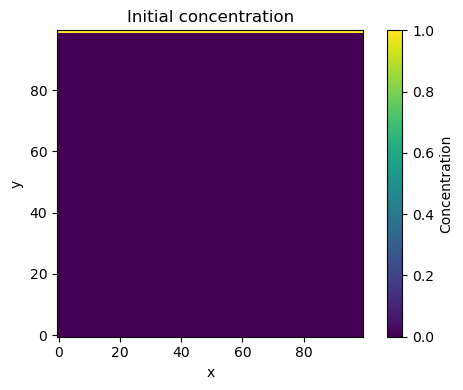

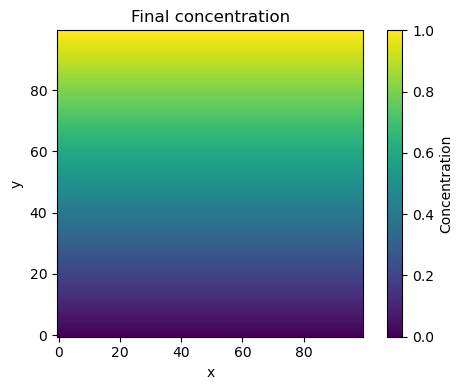

In [161]:
Nx = 100
omega = 1.7

c = np.zeros((Nx, Nx))
c[:, -1] = 1
c_init = c.copy()

obj = np.zeros((Nx, Nx), dtype=int)  # growing object
obj[Nx//2, 0] = 1

c, iter, converged = sor_parallel(c, omega, obj)
plot_laplace_grid(c_init, 'Initial concentration', 'initial_concentration')
plot_laplace_grid(c, 'Final concentration', 'final_concentration')

In [165]:
def simulate_dla_growth_model(Nt, Nx=100, max_sor_iter=1_000, omega=1.7, epsilon=1e-6):
    '''Simulates the Diffusion Limited Aggregation (DLA) growth model'''
    c = np.zeros((Nx, Nx))
    c[:, -1] = 1  # top is source

    # Optimization: initial guess for stable concentration profile using analytical solution
    y = np.linspace(0, 1, Nx)
    for i, y_i in enumerate(y):
        c[:, i] = y_i

    # Object is sink
    obj = np.zeros((Nx, Nx), dtype=int)
    obj[Nx//2, 0] = 1  # seed particle at the center of the bottom row

    for iter in tqdm(range(Nt)):
        c, sor_iter, converged = sor_parallel(
            c, omega, obj, epsilon, max_sor_iter)
        
        if not converged:
            raise ValueError(f'SOR convergence for DLA time step {iter} not reached after {sor_iter} iterations. ' + 
                             'Increase `max_iterations` or decrease `epsilon`.')
        else:
            info(f'SOR converged after {sor_iter} iterations.')

        growth_candidates = get_candidates(obj)
        candidate_probabilities = get_candidate_probabilities(
            c, growth_candidates)
        
        indices_candidate = np.linspace(0, len(growth_candidates)-1, len(growth_candidates), dtype=int)
        
        idx_chosen = np.random.choice(indices_candidate, p=candidate_probabilities)

        selected_candidate = growth_candidates[idx_chosen]
        info(f'Selected candidate: {tuple(selected_candidate)} with p={candidate_probabilities[idx_chosen]:.3f}.')

        obj[selected_candidate[0], selected_candidate[1]] = 1
        info(f'{np.count_nonzero(obj)} non-zero object elements after iteration {iter}.')

    return c, obj, iter


def get_candidates(obj):
    '''Utility functionality to get the van Neumann (Manhattan distance = 1) neighbors (growth candidates) of the object.
    Returns a numpy array of the indices of the growth candidates'''
    # Get indices where obj matrix has value 1
    obj_indices = np.argwhere(obj == 1)
    growth_candidates = set()

    # van Neumann neighbors
    for i, j in obj_indices:
        if obj[i-1, j] == 0:
            growth_candidates.add((i-1, j))
        if obj[(i+1) % Nx, j] == 0:
            growth_candidates.add(((i+1) % Nx, j))
        if j > 0 and obj[i, j-1] == 0:
            growth_candidates.add((i, j-1))
        if j < Nx-2 and obj[i, j+1] == 0:
            growth_candidates.add((i, j+1))

    if len(growth_candidates) == 0:
        warning(f'No more growth candidates found after {iter} iterations.')
    else:
        info(f'Found {len(growth_candidates)} growth candidates.')

    return np.array(list(growth_candidates))


def get_candidate_probabilities(c, growth_candidates):
    '''Utility functionality to get the probability of growth for each candidate based on its concentration.'''
    candidate_probabilities = np.zeros(len(growth_candidates))

    for i, (x, y) in enumerate(growth_candidates):
        candidate_probabilities[i] = c[x, y]

    sum_probabilities = np.sum(candidate_probabilities)

    if sum_probabilities <= 0:
        raise ValueError(
            'Sum of probabilities is (less than or equal) zero but neighbors were found. Either all neighbors have concentration 0 (unlikely), below 0 (impossible) or there is another issue. Please check the concentration matrix.')
    candidate_probabilities /= sum_probabilities

    return candidate_probabilities

## TODO: Fix plotting of object on top of grid
## TODO: Fix negative probabilities in np.random.choice showing up roughly every 20 runs. Something at the borders? With 1 or 0 neighbors?

  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:SOR converged after 463 iterations.
INFO:root:Found 3 growth candidates.
INFO:root:Selected candidate: (50, 1) with p=1.000.
INFO:root:2 non-zero object elements after iteration 0.
INFO:root:SOR converged after 92 iterations.
INFO:root:Found 5 growth candidates.
INFO:root:Selected candidate: (50, 2) with p=0.534.
INFO:root:3 non-zero object elements after iteration 1.
INFO:root:SOR converged after 181 iterations.
INFO:root:Found 7 growth candidates.
INFO:root:Selected candidate: (50, 3) with p=0.391.
INFO:root:4 non-zero object elements after iteration 2.
INFO:root:SOR converged after 312 iterations.
INFO:root:Found 9 growth candidates.
INFO:root:Selected candidate: (51, 2) with p=0.102.
INFO:root:5 non-zero object elements after iteration 3.
INFO:root:SOR converged after 125 iterations.
INFO:root:Found 9 growth candidates.
INFO:root:Selected candidate: (50, 4) with p=0.333.
INFO:root:6 non-zero object elements after iteration 4.
INFO:roo

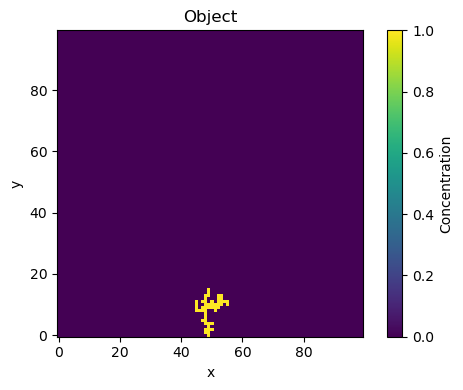

In [173]:
Nt = 50
c, obj, iter = simulate_dla_growth_model(Nt)
plot_laplace_grid(obj, 'Object', 'object_imshow')
# plot_laplace_grid(c, obj, 'Final concentration', 'final_concentration_dla')